# Lecture 19: Least squares fitting

## Motivation

-   Suppose we are given data point representing a quantity over time.

-   We want to represent the graph of this data as a simple curve.

-   The examples on the following slide show the fitting of two different curves through some experimental data:

    -   a straight line;
    -   a quadratic curve.

### Weekly earnings

In [1]:
from datetime import datetime as dt
import pandas as pd
import requests
from io import BytesIO

data_url = "http://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/averageweeklyearningsearn01/current/earn01nov2024.xls"
r = requests.get(data_url)
df = pd.read_excel(BytesIO(r.content), sheet_name="1. AWE Total Pay")
df = df.iloc[:, [0, 1]]
df.columns = ["date", "earnings"]
df = df.dropna()
# since 2008
df = df[df["date"] > dt(2008, 1, 1)]


def to_days(date):
    return float((date - dt(2008, 1, 1)).days)


days = df.apply(lambda row: to_days(row.date), axis=1)

Raw data for weekly earnings:

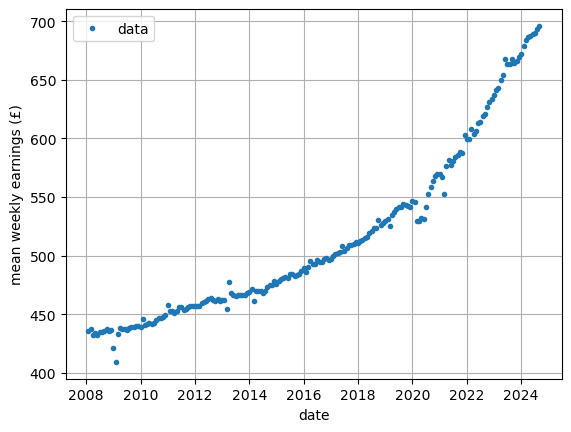

In [2]:
from matplotlib import pyplot as plt

plt.plot(df["date"], df["earnings"], ".", label="data")
plt.xlabel("date")
plt.ylabel("mean weekly earnings (£)")
plt.grid()
plt.legend()
plt.show()

Raw data for weekly earning with a straight line of best fit:

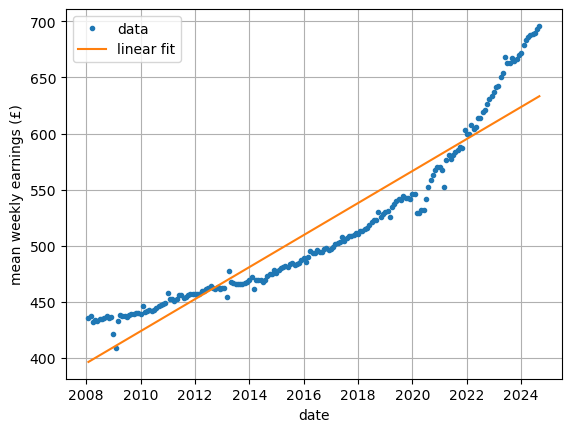

In [3]:
import numpy as np


def fit_line(x, y):
    A = np.array([[d, 1] for d in x])
    b = np.array([[e] for e in y])

    AtA = A.T @ A
    Atb = A.T @ b

    coef = np.linalg.solve(AtA, Atb)
    return lambda t: coef[0] * t + coef[1]


fit1 = fit_line(days, df["earnings"])

plt.plot(df["date"], df["earnings"], ".", label="data")
plt.plot(df["date"], fit1(days), label="linear fit")
plt.xlabel("date")
plt.ylabel("mean weekly earnings (£)")
plt.grid()
plt.legend()
plt.show()

Raw data for weekly earnings with a quadric curve of best fit:

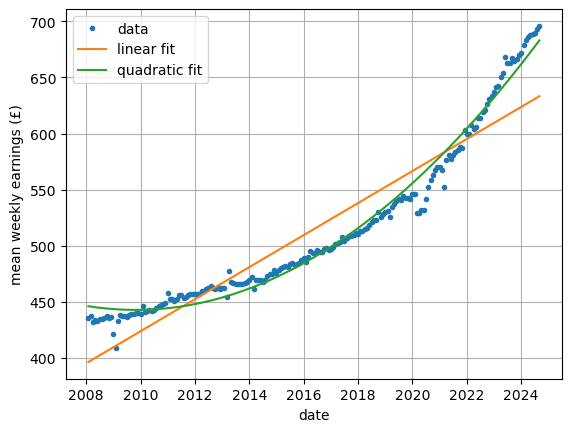

In [4]:
def fit_quad(x, y):
    A = np.array([[d * d, d, 1] for d in x])
    b = np.array([[e] for e in y])

    AtA = A.T @ A
    Atb = A.T @ b

    coef = np.linalg.solve(AtA, Atb)
    return lambda t: coef[0] * t * t + coef[1] * t + coef[2]


fit2 = fit_quad(days, df["earnings"])

plt.plot(df["date"], df["earnings"], ".", label="data")
plt.plot(df["date"], fit1(days), label="linear fit")
plt.plot(df["date"], fit2(days), label="quadratic fit")
plt.xlabel("date")
plt.ylabel("mean weekly earnings (£)")
plt.grid()
plt.legend()
plt.show()

[Data source, ons](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/averageweeklyearningsearn01),
[[xls](http://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/averageweeklyearningsearn01/current/earn01nov2024.xls)]

### An example of best linear fit

Suppose that the following measured data, $y$, is observed at different times $t$:

$$
\begin{array}{c|cccc}
t & 1 & 2 & 3 & 4 \\
\hline
y & 1 & 1.5 & 2.5 & 3.5
\end{array}
$$

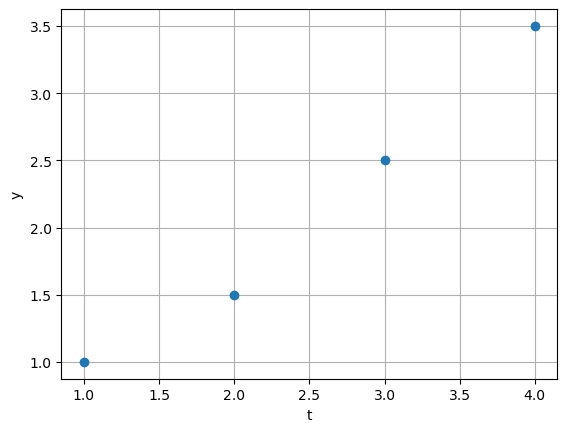

In [5]:
tt = [1.0, 2.0, 3.0, 4.0]
yy = [1.0, 1.5, 2.5, 3.5]

plt.plot(tt, yy, "o")

plt.xlabel("t")
plt.ylabel("y")
plt.grid()
plt.show()

-   Consider representing this data as a straight line:

    $$
    y = mt + c
    $$

-   An *exact fit* would require the following equations to be satisfied:

    $$
    \begin{aligned}
    m \times 1 + c & = 1 \\
    m \times 2 + c & = 1.5 \\
    m \times 3 + c & = 2.5 \\
    m \times 4 + c & = 3.5.
    \end{aligned}
    $$

    We recognise this as a system of linear equations for $(m, c)$ - but there are too many equations!!

(quadratic-fit)=
### An example of best quadratic fit

Suppose that the following measured data, $y$, is observed at different times $t$:

$$
\begin{array}{c|ccccc}
t & -1.0 & -0.5 & 0  & 0.5 & 1.0 \\
\hline
y & 1.0 & 0.5 & 0.0 & 0.5 & 2.0
\end{array}
$$

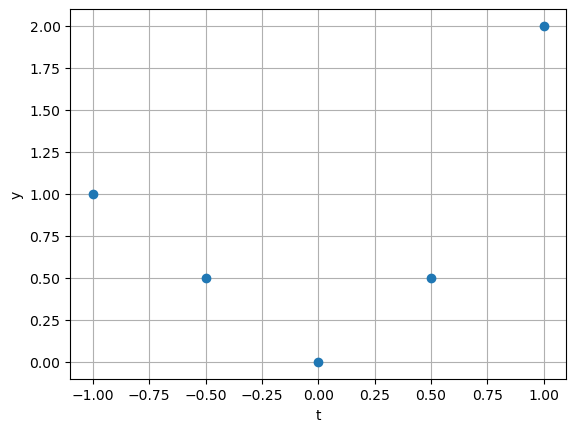

In [6]:
tt = [-1.0, -0.5, 0.0, 0.5, 1.0]
yy = [1.0, 0.5, 0.0, 0.5, 2.0]

plt.plot(tt, yy, "o")

plt.xlabel("t")
plt.ylabel("y")
plt.grid()
plt.show()

-   Consider representing this data as a quadratic line:

    $$
    y = a + b t + c t^2
    $$

-   An *exact fit* would require the following equations to be satisfied:

    $$
    \begin{aligned}
    a + b \times -1 + c \times (-1)^2 & = 1 \\
    a + b \times -0.5 + c \times (-0.5)^2 & = 0.5 \\
    a + b \times 0 + c \times 0^2 & = 0 \\
    a + b \times 0.5 + c \times 0.5^2 & = 0.5 \\
    a + b \times 1 + c \times 1^2 & = 2.
    \end{aligned}
    $$

    We recognise this as a system of linear equations for $(a, b, c)$ - but there are too many equations!!

## Best approximation

-   Given that there is no *exact fit* solution to these **overdetermined systems** of equations what should we do?

-   Recall the definition of the **residual** for the system $A \vec{x} = \vec{b}$:

    $$
    \vec{r} = \vec{b} - A \vec{x},
    $$

    -   When $\vec{r} = \vec{0}$, then $\vec{x} = \vec{x}^*$ the exact solution.
    -   When there is no exact solution the next best thing is to make $\vec{r}$ as small as possible.
    -   This means finding $\vec{x}$ that **minimises** $\| \vec{r} \|^2$.

## The normal equations

It turns out that the $\vec{x}$ that minimises $\| \vec{b} - A \vec{x} \|^2$ is the same $\vec{x}$ that satisfies that following *square* systems of equations:

$$
A^T A \vec{x} = A^T \vec{b}.
$$

-   These equations are referred to as the **normal equations** for the overdetermined system $A \vec{x} = \vec{b}$.

-   The square matrix $A^T A$ is generally non-singular (i.e., the solution is unique).

-   You can find this solution using Gaussian elimination (for example).

-   The normal equations, when solved, give the **best solution** to the original problem in the sense of minimising the Euclidean norm of the residual.

### Example I

1.  Find the least squares approximation to the [quadratic fit example](#quadratic-fit).

The residual is given by

$$
\begin{aligned}
\vec{r} & = \vec{b} - A \vec{x} \\
& = \begin{pmatrix} 1 \\ 0.5 \\ 0 \\ 0.5 \\ 2 \end{pmatrix} -
\begin{pmatrix}
1 & -1 & 1 \\
1 & -0.5 & 0.25 \\
1 & 0 & 0 \\
1 & 0.5 & 0.25 \\
1 & 1 & 1
\end{pmatrix}
\begin{pmatrix}
x_1 \\ x_2 \\ x_3
\end{pmatrix}
\end{aligned}
$$

We want to find $\vec{x}$ that minimises

$$
\| \vec{r} \|^2 = \| \vec{b} - A \vec{x} \|^2.
$$

The left and right hand sides of the normal equations are given by

$$
\begin{aligned}
A^T A & =
\begin{pmatrix}
1 & 1 & 1 & 1 & 1 \\
-1 & -0.5 & 0 & 0.5 & 1 \\
1 & 0.25 & 0 & 0.25 & 1
\end{pmatrix}
\begin{pmatrix}
1 & -1 & 1 \\
1 & -0.5 & 0.25 \\
1 & 0 & 0 \\
1 & 0.5 & 0.25 \\
1 & 1 & 1
\end{pmatrix} \\
& =
\begin{pmatrix}
5 & 0 & 2.5 \\
0 & 2.5 & 0 \\
2.5 & 0 & 2.125
\end{pmatrix}
\end{aligned}
$$

and

$$
A^T \vec{b} =
\begin{pmatrix}
1 & 1 & 1 & 1 & 1 \\
-1 & -0.5 & 0 & 0.5 & 1 \\
1 & 0.25 & 0 & 0.25 & 1
\end{pmatrix}
\begin{pmatrix} 1 \\ 0.5 \\ 0 \\ 0.5 \\ 2 \end{pmatrix}
 =
\begin{pmatrix}
4 \\ 1 \\ 3.25
\end{pmatrix}
$$

We can apply Gaussian elimination to solve this problem (only one row operation is required!). The algorithm gives:

$$
\begin{pmatrix}
5 & 0 & 2.5 \\
0 & 2.5 & 0 \\
0 & 0 & 0.875 \\
\end{pmatrix}
\begin{pmatrix}
x_1 \\ x_2 \\ x_3
\end{pmatrix}
 =
\begin{pmatrix}
4 \\ 1 \\ 1.25
\end{pmatrix},
$$

and backward substitution gives (to 4 significant figures)

$$
\vec{x} = (0.08571, 0.4000, 1.429).
$$

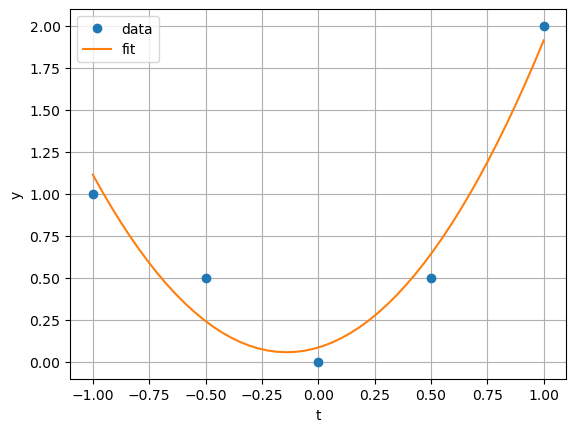

In [7]:
tt = [-1.0, -0.5, 0.0, 0.5, 1.0]
yy = [1.0, 0.5, 0.0, 0.5, 2.0]


plt.plot(tt, yy, "o", label="data")

fit = fit_quad(tt, yy)
tt = np.linspace(min(tt), max(tt))
fitt = fit(tt)

plt.plot(tt, fitt, label="fit")

plt.xlabel("t")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

### Example 2 (homework)

2.  Find the least square approximation to the system given by

    $$
    \begin{pmatrix}
    -2 & 2 & -1 \\
    0 & 1 & 0 \\
    3 & 1 & -2 \\
    1 & 1 & 4
    \end{pmatrix}
    \begin{pmatrix}
    x_1 \\ x_2 \\ x_3
    \end{pmatrix}
     =
     \begin{pmatrix}
     2 \\ 1 \\ 0 \\ -3
     \end{pmatrix}
    $$

## Problems with the normal equations

Consider the matrix $A = \begin{pmatrix} 1 & 1 \\ \varepsilon & 0 \\ 0 & \varepsilon \end{pmatrix}$, which gives

$$
A^T A = \begin{pmatrix}
1 + \varepsilon^2 & 1 \\
1 & 1 + \varepsilon^2.
\end{pmatrix}
$$

If $\varepsilon \approx \sqrt{eps}$ then the effects of rounding error can make $A^T A$ appear to be singular.

See also: Nick Higham, [Seven sins of numerical linear algebra](https://nhigham.com/2022/10/11/seven-sins-of-numerical-linear-algebra/)

### Sensitivity and conditioning

-   The condition number of a square matrix $A$ describes how close that matrix is to being singular.

-   If the condition number is larger then $A$ is "close" to being singular.

-   When the condition number is very large it is likely that the effects of rounding errors will be most serious: we refer to such a system as being ill-conditioned.

-   The normal equations are typically quite ill-conditioned and so it is essential to use high precision arithmetic to solve them and specialised algorithms.

## Summary

-   Overdetermined systems are common in data modelling and they typically have no solution.

-   Even so, it is possible to find a *closest* solution to the problem.

-   It is common to measure this closeness in the Euclidean norm and this leads naturally to the least squares approximation.

-   A solution to this problem can be found by solving the normal equations but can must be taken to use arithmetic with sufficient precision and specialised algorithms.

## Further reading


- Wikipedia: [Curve fitting](https://en.wikipedia.org/wiki/Curve_fitting)
- Wikipedia: [Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
- Maths is fun: [Least Squares Regression](https://www.mathsisfun.com/data/least-squares-regression.html)

- Cross Validated StackExchange: [Is a model fitted to data or is data fitted to a model?](https://stats.stackexchange.com/questions/399094/is-a-model-fitted-to-data-or-is-data-fitted-to-a-model)

The [slides used in the lecture](./lec19_.ipynb) are also available